In [1]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime

from data.toy_data.hyperbolic import hyperbolic
from data.toy_data.circle import circle
from data.toy_data.spiral import twospirals

from src.diffeomorphisms.iresnet_euclidean_product import i_ResNet_into_Euclidean
from src.manifolds.euclidean import Euclidean
from src.manifolds.pull_back_manifold import PullBackManifold
from src.riemannian_autoencoder import Curvature_Corrected_Riemannian_Autoencoder
from src.riemannian_autoencoder.low_rank_approximation.naive_tsvd import naive_low_rank_approximation
from src.utils.isomap import make_adjacency, get_path, isomap
from src.utils.neural_network.distance_data_set import DistanceData

# set seed
torch.manual_seed(31)

In [2]:
# experiment settings
train_with_subspace_regularisation = False
train_with_isometry_regularisation = False

In [35]:
# data parameters
num_data = 51
num_test_data = 500
noise = 0.1
test_noise = 0.5
cut_off_constant = 75

# iresnet parameters
s_nBlocks = 100 
s_max_iter_inverse = 50
s_int_features = 10 
s_coeff = 0.8 
s_n_power_iter = 10 

# variational problem parameters
alpha_sub = 10.
alphs_iso = 1/100

# training parameters
batch_size = 32
n_epochs = 20
lr = 1e-3
beta_1 = 0.9
beta_2 = 0.99

Spiral data

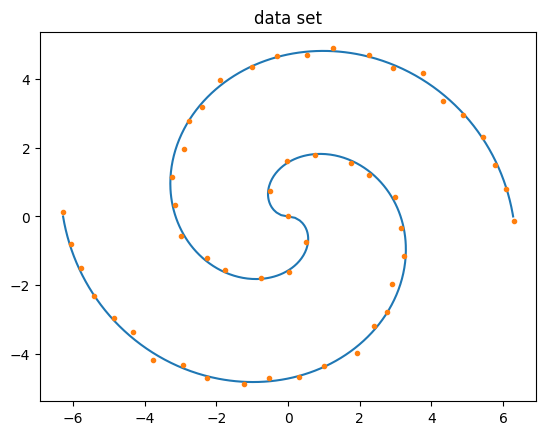

In [4]:
s_data_manifold = twospirals(int((num_test_data-1)/2), noise=0.)
s_data = twospirals(int((num_data-1)/2), noise=noise)

plt.title('data set')
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.show()

In [5]:
# Construct similarity graph and compute geodesic distances
cut_off = cut_off_constant / num_data # 1.5 make sure to have full data path
pairwise_distances, predecessors = make_adjacency(s_data.T,eps=cut_off, return_predecessors=True)
pairwise_distances = torch.from_numpy(pairwise_distances)
predecessors = torch.from_numpy(predecessors)

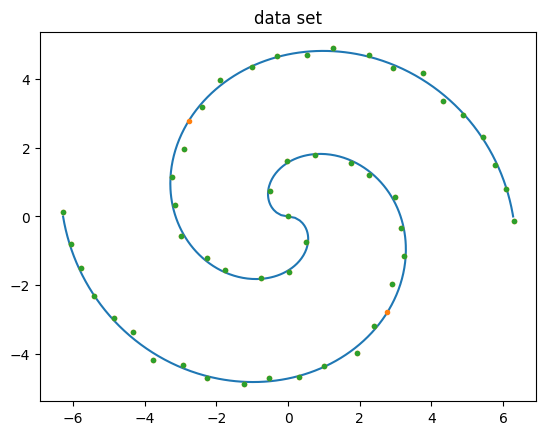

In [6]:
# construct geodesics
path = get_path(predecessors, pairwise_distances, 0, int(num_data-1))
# plot geodesic
plt.title('data set')
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.plot(s_data[path,0], s_data[path,1], '.')
plt.show()

In [7]:
dataset = DistanceData(s_data, pairwise_distances)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

2550


In [8]:
# construct pull-back manifold
s_offset = s_data[int((num_data-1)/2)] 
print(f"z = {s_offset}")
_,_, s_orthogonal = torch.linalg.svd(s_data)
print(f"O = {s_orthogonal}")

s_diffeo = i_ResNet_into_Euclidean([1,1], s_offset, s_orthogonal, 
                              nBlocks=s_nBlocks, 
                              max_iter_inverse=s_max_iter_inverse, 
                              int_features=s_int_features, 
                              coeff=s_coeff, 
                              n_power_iter=s_n_power_iter) 
s_M = PullBackManifold(s_diffeo)

z = tensor([0., 0.])
O = tensor([[ 0.8233,  0.5676],
        [ 0.5676, -0.8233]])


Learn diffeomorphism

In [9]:
# Train
optimizer = torch.optim.Adam(s_M.diffeo.phi.parameters(), lr=beta_1, betas=(beta_1,beta_2))

# main training loop
num_minibatches = 10 #display the loss after these many mini-batches

for epoch in range(n_epochs):
    total_pairwise_distance_loss = 0.0
    total_subspace_loss = 0.0
    total_isometry_loss = 0.0
      
    for idx, (data_i, data_j, pairwise_distance_ij) in enumerate(dataloader):
      
        x_i = data_i
        x_j = data_j
        d_ij = pairwise_distance_ij
        
        phi_i = s_M.diffeo.forward(x_i)
        phi_j = s_M.diffeo.forward(x_j)

        # compute metric tensor at points
        g_i = s_M.metric_tensor_in_std_basis(x_i)
        g_j = s_M.metric_tensor_in_std_basis(x_j)
        
        # optimize the net
        d_M_ij = s_M.distance(x_i[:,None,:], x_j[:,None,:]).squeeze()
        pairwise_distance_loss = torch.mean((d_M_ij - d_ij)**2) # (\|phi_i - phi_j\| - d_ij)^2
        
        # subspace loss
        if train_with_subspace_regularisation:
            subspace_loss_i = torch.mean(phi_i[1].norm(1,-1))
            subspace_loss_j = torch.mean(phi_j[1].norm(1,-1))
            subspace_loss = alpha_sub * (subspace_loss_i + subspace_loss_j)/2
        else:
            subspace_loss = torch.tensor([0.])
    
        # isometry loss
        if train_with_isometry_regularisation:
            isometry_loss_i = torch.mean(torch.sum((g_i - torch.eye(2)[None])**2, (1,2)))
            isometry_loss_j = torch.mean(torch.sum((g_j - torch.eye(2)[None])**2, (1,2)))
            isometry_loss = alpha_iso * (isometry_loss_i + isometry_loss_j)/2 
        else:
            isometry_loss = torch.tensor([0.])
        
        loss = pairwise_distance_loss + subspace_loss + isometry_loss
        
        # update networks
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_pairwise_distance_loss += pairwise_distance_loss.item()
        total_subspace_loss += subspace_loss.item()
        total_isometry_loss += isometry_loss.item()

        if(idx % num_minibatches == num_minibatches-1):
            avg_pairwise_distance_loss = total_pairwise_distance_loss/num_minibatches
            avg_subspace_loss = total_subspace_loss/num_minibatches
            avg_isometry_loss = total_isometry_loss/num_minibatches
            
            print("epoch[{}/{}] mini-batch[{}/{}] avg_pwd_loss {:.6f} avg_subspace_loss {:.6f} avg_isometry_loss {:.6f}"\
                  .format(epoch+1, n_epochs, idx+1, len(dataloader), avg_pairwise_distance_loss, avg_subspace_loss, avg_isometry_loss))
            total_pairwise_distance_loss = 0.0
            total_subspace_loss = 0.0
            total_isometry_loss = 0.0

/Users/wdiepeveen/Documents/PhD/Projects/10 - Learning Riemannian Geometry/src/article/Pulling-back-symmetric-Riemannian-geometry-for-data-analysis/src/diffeomorphisms/iresnet_euclidean_product.py:75: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  output = torch.zeros(X.shape).T


epoch[1/20] mini-batch[20/80] avg_pwd_loss 86.040561 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[1/20] mini-batch[40/80] avg_pwd_loss 55.935532 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[1/20] mini-batch[60/80] avg_pwd_loss 51.256714 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[1/20] mini-batch[80/80] avg_pwd_loss 48.263157 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[2/20] mini-batch[20/80] avg_pwd_loss 38.291735 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[2/20] mini-batch[40/80] avg_pwd_loss 32.558642 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[2/20] mini-batch[60/80] avg_pwd_loss 23.034556 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[2/20] mini-batch[80/80] avg_pwd_loss 16.590620 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[3/20] mini-batch[20/80] avg_pwd_loss 10.632527 avg_subspace_loss 0.000000 avg_isometry_loss 0.000000
epoch[3/20] mini-batch[40/80] avg_pwd

KeyboardInterrupt: 

In [10]:
#save the model
trained_networks_path = os.path.join("models", "spiral")
os.makedirs(trained_networks_path, exist_ok=True)

now = datetime.now()
date_time = now.strftime("%Y_%m_%d_%H_%M_%S")
s_phi_path = os.path.join(trained_networks_path, "i_resnet_euclidean_product_{}_blocks_{}_int_features_{}_epochs_{}_subspace_reg_{}_isometry_reg_{}.pt".format(s_nBlocks, s_int_features, n_epochs, train_with_subspace_regularisation, train_with_isometry_regularisation, date_time))

# save z, O and phi TODO
torch.save(s_M.diffeo.phi.state_dict(), s_phi_path) 

Evaluate learned geometry

In [23]:
# load diffeomorphism
if True:
    trained_networks_path = os.path.join("models", "spiral")
    s_phi_path = os.path.join(trained_networks_path, "i_resnet_euclidean_product_100_blocks_10_int_features_20_epochs_False_subspace_reg_False_isometry_reg.pt")
    
    s_diffeo = i_ResNet_into_Euclidean([1,1], s_offset, s_orthogonal, 
                              nBlocks=s_nBlocks, 
                              max_iter_inverse=s_max_iter_inverse, 
                              int_features=s_int_features, 
                              coeff=s_coeff, 
                              n_power_iter=s_n_power_iter) 
    s_diffeo.phi.load_state_dict(torch.load(s_phi_path))
    s_M = PullBackManifold(s_diffeo)

In [24]:
# choose special points
s_z1 = s_data[path,:][0][None]
s_z2 = s_data[path,:][-1][None]
s_z3 = torch.tensor([0., 0.])[None]
s_z4 = s_data[20,:][None]

In [25]:
# compute geodesics
t = torch.linspace(0,1,100)
s_gamma_12_t =  s_M.geodesic(s_z1, s_z2, t)
s_gamma_13_t =  s_M.geodesic(s_z1, s_z3, t)

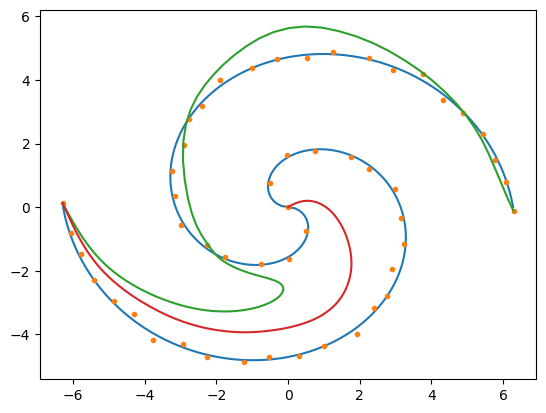

In [26]:
# plot geodesics
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.plot(s_gamma_12_t.squeeze().detach().numpy()[:,0], s_gamma_12_t.squeeze().detach().numpy()[:,1])
plt.plot(s_gamma_13_t.squeeze().detach().numpy()[:,0], s_gamma_13_t.squeeze().detach().numpy()[:,1])
plt.show()

In [27]:
# compute barycentre
s_barycentre = s_M.barycentre(s_data[None])

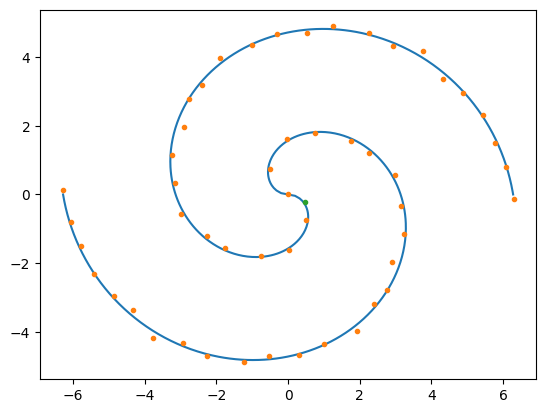

In [28]:
# plot barycentre
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
plt.plot(s_data[:,0], s_data[:,1], '.')
plt.plot(s_barycentre[:,0].detach().numpy(), s_barycentre[:,1].detach().numpy(), '.')
plt.show()

In [29]:
# compute logs to all data
s_logs = s_M.log(s_barycentre * torch.ones((num_data,1)), s_data[:,None])[:,0]

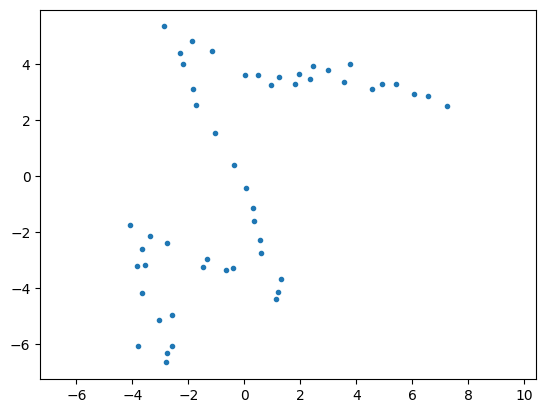

In [30]:
# plot logs
plt.plot(s_logs.squeeze().detach().numpy()[:,0], s_logs.squeeze().detach().numpy()[:,1], '.')
plt.axis('equal')
plt.show()

In [31]:
# rank 1 approximation
s_z = s_barycentre.squeeze()
s_R_z, s_U = naive_low_rank_approximation(s_M, s_z, s_data, 1)
s_w_z = s_R_z / s_M.norm(s_z[None], s_R_z[None])[:,None]
print(s_w_z)
print(s_U.shape)

tensor([[-0.1992, -0.2683]], grad_fn=<DivBackward0>)
torch.Size([1, 51])


In [32]:
# compute error
s_logs_approx = torch.einsum("kN,kd->Nd", s_U, s_R_z)

s_tangent_space_error = torch.sum(s_M.norm(s_z[None], s_logs_approx[None] - s_logs[None])**2)
print(s_tangent_space_error)

s_manifold_error = torch.sum(s_M.distance(s_data[:,None], s_M.exp(s_z[None] * torch.ones((num_data,1)), s_logs_approx[:,None])[:,0][:,None])**2)
print(s_manifold_error)

s_l2_error = torch.sum((s_data[:,None] - s_M.exp(s_z[None] * torch.ones((num_data,1)), s_logs_approx[:,None])[:,0][:,None])**2)
print(s_l2_error)

tensor(27.6838, grad_fn=<SumBackward0>)
tensor(27.6840, grad_fn=<SumBackward0>)
tensor(99.4150, grad_fn=<SumBackward0>)


In [33]:
# construct CC-RAE
s_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(s_M, s_z, s_w_z)

In [36]:
# project noisy data onto manifold with RAE
noisy_s_data = twospirals(int((num_test_data-1)/2), noise=test_noise) 
projected_s_mesh = s_rae_w_z.project_on_manifold(noisy_s_data)

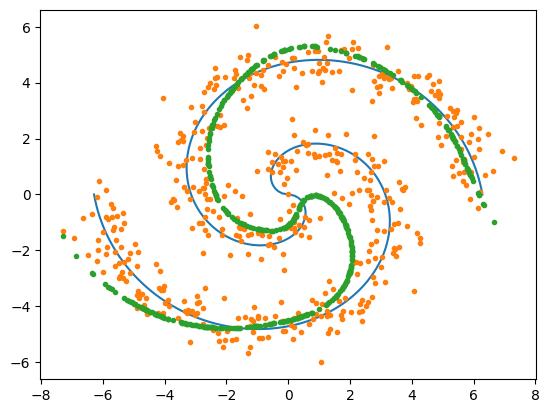

In [37]:
# plot results
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1])
plt.plot(noisy_s_data[:,0], noisy_s_data[:,1], '.')
plt.plot(projected_s_mesh.cpu().detach().numpy()[:,0], projected_s_mesh.cpu().detach().numpy()[:,1], '.')
plt.show()